In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d6c0ac54d52361466d1061b7ca23586f130158839c6764e3e2efaa0fb704c8aa
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")

df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,time,event,age,sex,bmi,bp,comorbidity,treatment
0,4.30,1,68,1,28.2,110,2,0
1,35.48,0,81,0,18.0,133,0,1
2,28.70,0,58,1,31.2,100,1,0
3,18.70,0,44,1,31.4,157,0,0
4,45.86,0,72,0,23.4,90,1,0


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, test_df.shape


((960, 8), (240, 8))

In [ ]:
cph = CoxPHFitter()

cph.fit(
    train_df,
    duration_col="time",
    event_col="event"
)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 960 total observations, 707 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 960
number of events observed = 253
   partial log-likelihood = -1492.65
         time fit was run = 2025-11-16 10:20:53 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
sex         -0.05      0.95      0.13           -0.30            0.20                0.74                1.22
bmi         -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
bp           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
comorbidity -0.11      0.89      0.06           -0.23           -0.00                0.80                1.00
treatment    0.24      1.28      0.13           -0.01            0.50                0.99                1.64

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -1.41 0.16      2.66
sex            0.00 -0.39 0.70      0.52
bmi            0.00 -0.06 0.96      0.07
bp             0.00  0.45 0.66      0.61
comorbidity    0.00 -2.02 0.04      4.53
treatment      0.00  1.91 0.06      4.17
---
Concordance = 0.56
Partial AIC = 2997.30
log-likelihood ratio test = 10.35 on 6 df
-log2(p) of ll-ratio test = 3.18

In [ ]:
# Predict partial hazards for test data
test_pred = cph.predict_partial_hazard(test_df)

# C-index
c_index = concordance_index(
    test_df["time"],
    -test_pred,
    test_df["event"]
)

print("Test C-index:", c_index)

Test C-index: 0.546996556561663


In [ ]:
cph.check_assumptions(train_df, p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [ ]:
# Run in a notebook cell with a leading ! or in terminal
!pip install lifelines scikit-learn matplotlib joblib
# Optional (for ElasticNet Cox)
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import joblib
import os

# load
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")
train_df, test_df = df.sample(frac=0.8, random_state=42), df.drop(df.sample(frac=0.8, random_state=42).index)  # fallback if you didn't split earlier
# If you already have train_df/test_df from prior cell, comment the above two lines and keep those variables.
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

Train shape: (960, 8) Test shape: (240, 8)


In [ ]:
def cv_penalizer_lifelines(df_train, penalizer_grid, n_splits=4, random_state=0):
    """
    Returns dict penalizer -> mean C-index (CV) using lifelines CoxPHFitter.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {}
    Xy = df_train.reset_index(drop=True)
    for pen in penalizer_grid:
        cidxs = []
        for train_idx, val_idx in kf.split(Xy):
            train = Xy.iloc[train_idx]
            val = Xy.iloc[val_idx]
            cph = CoxPHFitter(penalizer=pen)
            # fit
            cph.fit(train, duration_col="time", event_col="event", show_progress=False)
            preds = cph.predict_partial_hazard(val.drop(columns=["time", "event"]))
            cidx = concordance_index(val["time"], -preds, val["event"])
            cidxs.append(cidx)
        results[pen] = np.mean(cidxs)
        print(f"penalizer={pen:.5f} -> CV C-index={results[pen]:.4f}")
    return results

# Define grid and run CV
pen_grid = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
cv_results = cv_penalizer_lifelines(train_df, pen_grid, n_splits=4)
best_pen = max(cv_results, key=cv_results.get)
print("Best penalizer:", best_pen, "CV C-index:", cv_results[best_pen])

penalizer=0.00010 -> CV C-index=0.5339
penalizer=0.00100 -> CV C-index=0.5337
penalizer=0.01000 -> CV C-index=0.5336
penalizer=0.05000 -> CV C-index=0.5319
penalizer=0.10000 -> CV C-index=0.5313
penalizer=0.50000 -> CV C-index=0.5297
penalizer=1.00000 -> CV C-index=0.5286
penalizer=5.00000 -> CV C-index=0.5273
Best penalizer: 0.0001 CV C-index: 0.5339114208784853


In [ ]:
os.makedirs("../results/model_checkpoints", exist_ok=True)

best_cph = CoxPHFitter(penalizer=best_pen)
best_cph.fit(train_df, duration_col="time", event_col="event")
best_cph.print_summary()

# Save model (joblib recommended for lifelines objects)
joblib.dump(best_cph, "../results/model_checkpoints/cox_lifelines_penalized.pkl")
print("Saved model to ../results/model_checkpoints/cox_lifelines_penalized.pkl")

<lifelines.CoxPHFitter: fitted with 960 total observations, 709 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 960
number of events observed = 251
   partial log-likelihood = -1456.82
         time fit was run = 2025-11-16 10:21:36 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
sex         -0.08      0.92      0.13           -0.33            0.17                0.72                1.19
bmi          0.01      1.01      0.01           -0.01            0.03                0.99                1.03
bp          -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
comorbidity -0.13      0.88      0.06           -0.24           -0.02                0.79                0.98
treatment    0.24      1.27      0.13           -0.01            0.49                0.99                1.64

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -1.54 0.12      3.03
sex            0.00 -0.63 0.53      0.92
bmi            0.00  0.60 0.55      0.87
bp             0.00 -0.56 0.58      0.79
comorbidity    0.00 -2.28 0.02      5.47
treatment      0.00  1.89 0.06      4.09
---
Concordance = 0.57
Partial AIC = 2925.63
log-likelihood ratio test = 11.00 on 6 df
-log2(p) of ll-ratio test = 3.50

Saved model to ../results/model_checkpoints/cox_lifelines_penalized.pkl


In [ ]:
# load model if needed:
# best_cph = joblib.load("../results/model_checkpoints/cox_lifelines_penalized.pkl")

X_test = test_df.drop(columns=["time", "event"])
test_partial_hazard = best_cph.predict_partial_hazard(X_test)
test_cindex = concordance_index(test_df["time"], -test_partial_hazard, test_df["event"])
print("Test C-index (penalized Cox):", test_cindex)

# Attach predictions for inspection
test_df = test_df.copy()
test_df["partial_hazard"] = np.ravel(test_partial_hazard)
test_df.sort_values("partial_hazard", ascending=False).head(8)

Test C-index (penalized Cox): 0.5479267914383208


,time,event,age,sex,bmi,bp,comorbidity,treatment,partial_hazard
21,20.13,0,31,0,39.0,125,0,1,1.809527
337,6.57,0,36,0,27.7,91,0,1,1.723271
510,46.49,0,43,0,29.0,97,0,1,1.653870
1139,50.30,1,30,0,29.6,156,0,1,1.644011
600,32.51,0,45,0,32.8,130,0,1,1.595745
804,59.78,0,31,1,22.8,102,0,1,1.563705
995,2.03,1,33,0,32.5,107,1,1,1.552269
397,8.55,0,49,0,29.2,118,0,1,1.552028


,feature,coef_penalized,coef_unpenalized
5,treatment,0.241582,0.241690
4,comorbidity,-0.128075,-0.128136
1,sex,-0.080420,-0.080459
2,bmi,0.006086,0.006089
0,age,-0.005773,-0.005775
3,bp,-0.001435,-0.001436


<Figure size 800x500 with 0 Axes>

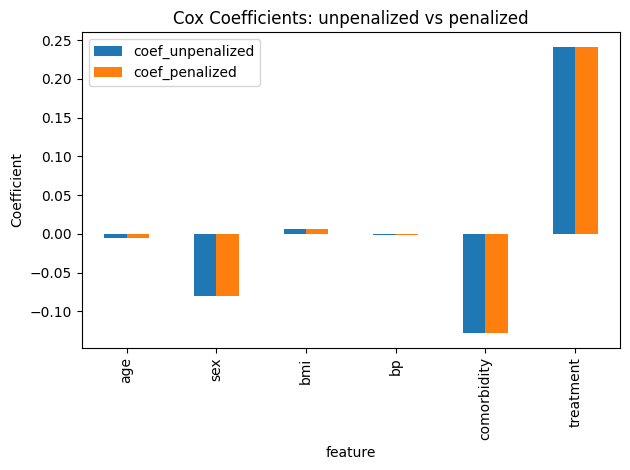

In [ ]:
# Fit an unpenalized Cox for comparison (optional)
cph_unpen = CoxPHFitter(penalizer=0.0)
cph_unpen.fit(train_df, duration_col="time", event_col="event")
coef_df = pd.DataFrame({
    "feature": best_cph.params_.index,
    "coef_penalized": best_cph.params_.values,
    "coef_unpenalized": cph_unpen.params_.loc[best_cph.params_.index].values
}).reset_index(drop=True)

# show table
display(coef_df.sort_values("coef_penalized", key=abs, ascending=False).head(20))

# Plot coefficients
plt.figure(figsize=(8,5))
coef_df.set_index("feature")[["coef_unpenalized","coef_penalized"]].plot(kind="bar")
plt.title("Cox Coefficients: unpenalized vs penalized")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()

In [ ]:
from lifelines import CoxPHFitter

# 1️⃣ Make a clean copy of the dataframe (remove partial_hazard if it exists)
clean_df = df.drop(columns=['partial_hazard'], errors='ignore')

# 2️⃣ Instantiate ElasticNet Cox model
cph_en = CoxPHFitter(
    penalizer=0.1,    # controls overall regularization strength
    l1_ratio=0.5      # 0 = Ridge, 1 = LASSO, 0.5 = ElasticNet
)

# 3️⃣ Fit the model
cph_en.fit(clean_df, duration_col='time', event_col='event')

# 4️⃣ See results
cph_en.print_summary()

<lifelines.CoxPHFitter: fitted with 1200 total observations, 876 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 1200
number of events observed = 324
   partial log-likelihood = -1974.72
         time fit was run = 2025-11-16 10:21:57 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
sex         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
bmi          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
bp           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
comorbidity -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
treatment    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -0.00 1.00      0.00
sex            0.00 -0.00 1.00      0.00
bmi            0.00  0.00 1.00      0.00
bp             0.00  0.00 1.00      0.00
comorbidity    0.00 -0.00 1.00      0.00
treatment      0.00  0.00 1.00      0.00
---
Concordance = 0.57
Partial AIC = 3961.44
log-likelihood ratio test = -0.00 on 6 df
-log2(p) of ll-ratio test = -0.00